In [2]:
# Description

# Prediction of the target variable exit_stop_id using the variables 
# datetime, route, direction, and stop_id as predictors. Because the 
# target variable is categorical with several categories and sparse, 
# only levels that appeared at least 500 times in the data were included. 
# The variable datetime denotes the date and was converted to a 3-level 
# categorical. The rest of the variables predictor variables were coded
# as integers. 

# The dataset was divided into a training set (80%) and a test set (20%).

# Algorithms: decision tree, k-NN, Random Forest, Bagging, Gradient Boosting, 
# Kernel ridge regression and Neural network.

# The parameters of the models were checked by search to optimize the 
# accuracy in the test set.
# The accuracy of the algorithms ranged from 40% (k-NN) to 63% (Bagging). 
# The neural network gave good results and further tuning can be done 
# to achieve higher accuracy.

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.kernel_ridge import KernelRidge
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import lightgbm as lgb

data = pd.read_csv("result_20210911.csv")
print("Data size before cleansing:", data.size)

# Remove rows where "exit_stop_id" or "stop_id" is empty
data = data.dropna(subset=['exit_stop_id', 'stop_id'])

# Drop unnecessary columns

data_cleaned = data.drop(columns=['GarNr', 'ValidTalonaId', 'TripCompanyCode', 'stop_name', "geometry", "exit_geometry", "exit_stop_name"])

# Transform date and time to categorical variable with 3 levels (Early, Mid-day and Late)

bins = ['00:00:00', '03:00:00', '11:00:00', '17:00:00', '23:59:59']
labels = ['Late', 'Early', 'Mid-Day', 'Late']
s = pd.to_timedelta(pd.to_datetime(data_cleaned['datetime']).dt.time.astype(str))
data_cleaned['datetime'] = pd.cut(s, bins=pd.to_timedelta(bins), labels=labels, ordered=False)

# Make exit_stop_id the target variable

if 'exit_stop_id' in data_cleaned.columns:
    data_copy = data_cleaned.copy()
    # Assign 'exit_stop_id' as the target variable
    y = data_copy['exit_stop_id']
    data = data_copy.drop(columns=['exit_stop_id'])

Data size before cleansing: 2070288


In [4]:
# Identify targets with less that 500 ocurrences and remove them from dataset

df = pd.value_counts(y).to_frame().reset_index()
stop_id_counts = data_copy["exit_stop_id"].value_counts()
stop_ids_to_delete = stop_id_counts[stop_id_counts < 500]

# Remove the rows corresponding to the rarest values

df = data_copy[~data_copy['exit_stop_id'].isin(stop_ids_to_delete.index)]

y = df['exit_stop_id']
data = df.drop(columns=['exit_stop_id'])
print("Data size after cleansing:", data.size)


# Convert categories to integers for classification

data["datetime"] = pd.factorize(data["datetime"])[0]
data["route"] = pd.factorize(data["route"])[0]
data["direction"] = pd.factorize(data["direction"])[0]
data["stop_id"] = pd.factorize(data["stop_id"])[0]
y = pd.factorize(y)[0]

# Create training and test subsets

x_train, x_test, y_train, y_test=train_test_split(data, y, test_size=0.20,random_state=0)

Data size after cleansing: 38148


C:\Users\ilian\AppData\Local\Temp\ipykernel_20416\1727544934.py:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  df = pd.value_counts(y).to_frame().reset_index()


In [5]:
# The algorithms that are used are

## Decision tree
## k-NN
## Random Forest
## Bagging
## Gradient Boosting
## Kernel ridge regression
## Neural network

In [6]:
# Decision tree

tree = DecisionTreeClassifier(random_state=2024)
tree.fit(x_train, y_train)
y_pred = tree.predict(x_test)
acc = accuracy_score(y_test, y_pred)
print("Tree Test Accuracy:", acc)

# k-NN

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
acc = accuracy_score(y_test, y_pred)
print("k-NN Test Accuracy:", acc)

# Bagging

bagging = BaggingClassifier(n_estimators=200, random_state=2024)
bagging.fit(x_train, y_train)
y_pred = bagging.predict(x_test)
score = accuracy_score(y_test, y_pred)
print(f"Bagging test accuracy score: {score}")

# Random Forest

rf = RandomForestClassifier(n_estimators=10, max_features = 'sqrt', random_state=2024)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
score = accuracy_score(y_test, y_pred)
print(f"Random Forest test accuracy score: {score}")

# Gradient Boosting 

gbr = GradientBoostingClassifier(n_estimators=200, learning_rate= 0.1, max_depth = 1, random_state=2024)
gbr.fit(x_train, y_train)
y_pred = gbr.predict(x_test)
score = accuracy_score(y_test, y_pred)
print(f"Gradient Boosting test accuracy score: {score}")

## Kernel ridge regression

model = KernelRidge(alpha = 0.1, kernel='rbf', gamma=1.0)
model.fit(x_train, y_train)
predictions = model.predict(x_test)
score = accuracy_score(y_test, y_pred)
print(f"Kernel ridge regression test accuracy score: {score}")

# XGBoost
xgboost_model = xgb.XGBClassifier(n_estimators=65, learning_rate=0.1, random_state=2024)
xgboost_model.fit(x_train, y_train) 
y_pred = xgboost_model.predict(x_test)
score = accuracy_score(y_test, y_pred)
print(f"XGBoost test accuracy score: {score}")

# LightGBM 
lgbm_model = lgb.LGBMClassifier(n_estimators=50, learning_rate=0.1, random_state=2024, verbose= -1)
lgbm_model.fit(x_train, y_train)
y_pred = lgbm_model.predict(x_test) 
score = accuracy_score(y_test, y_pred) 
print(f"LightGBM test accuracy score: {score}")

Tree Test Accuracy: 0.6907756813417191
k-NN Test Accuracy: 0.549266247379455
Bagging test accuracy score: 0.689203354297694
Random Forest test accuracy score: 0.6808176100628931
Gradient Boosting test accuracy score: 0.6373165618448637
Kernel ridge regression test accuracy score: 0.6373165618448637
XGBoost test accuracy score: 0.6933962264150944
LightGBM test accuracy score: 0.6986373165618449


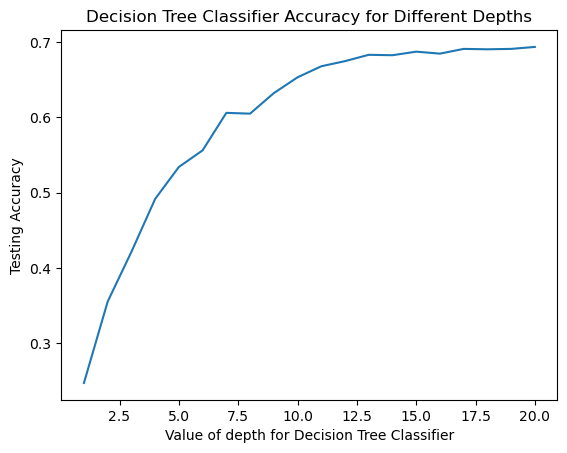

In [8]:
# Decision Tree

scores = []
depths = range(1, 21)
for depth in depths:
    tree = DecisionTreeClassifier(max_depth=depth, random_state=2024)
    tree.fit(x_train, y_train)
    y_pred = tree.predict(x_test)
    scores.append(accuracy_score(y_test, y_pred))

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(depths, scores)
plt.xlabel('Value of depth for Decision Tree Classifier')
plt.ylabel('Testing Accuracy')
plt.title('Decision Tree Classifier Accuracy for Different Depths')
plt.show()

Text(0, 0.5, 'Testing Accuracy')

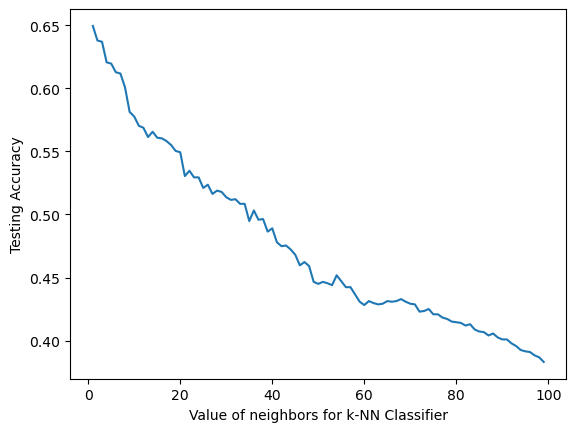

In [9]:
# k-NN

scores =[]
for k in range(1, 100, 1):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    scores.append(accuracy_score(y_test, y_pred))

plt.plot(range(1, 100), scores)
plt.xlabel('Value of neighbors for k-NN Classifier')
plt.ylabel('Testing Accuracy')

Text(0, 0.5, 'Testing Accuracy')

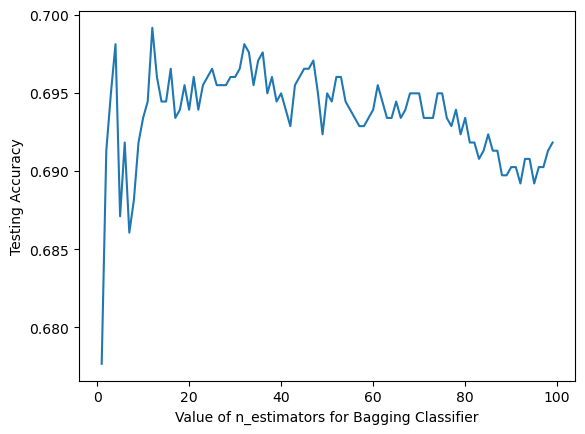

In [10]:
## Bagging for various n_estimators

scores =[]
for k in range(1, 100, 1):
    bagging = BaggingClassifier(n_estimators=k, n_jobs = -1, random_state=2024)
    bagging.fit(x_train, y_train)
    y_pred = bagging.predict(x_test)
    scores.append(accuracy_score(y_test, y_pred))

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(1, 100), scores)
plt.xlabel('Value of n_estimators for Bagging Classifier')
plt.ylabel('Testing Accuracy')

Text(0, 0.5, 'Testing Accuracy')

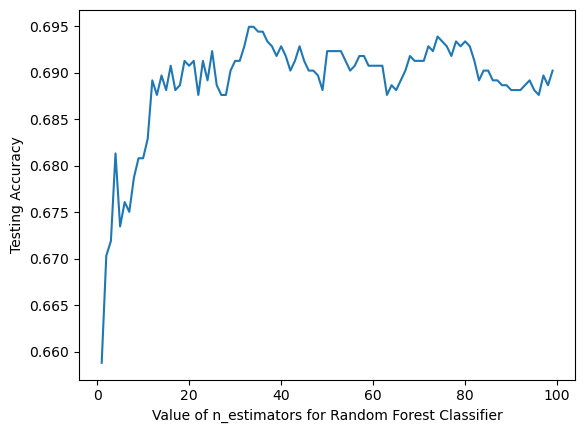

In [11]:
## Random Forest for various n_estimators

scores =[]
for k in range(1, 100):
    rfc = RandomForestClassifier(n_estimators=k, n_jobs = -1, random_state=2024)
    rfc.fit(x_train, y_train)
    y_pred = rfc.predict(x_test)
    scores.append(accuracy_score(y_test, y_pred))

plt.plot(range(1, 100), scores)
plt.xlabel('Value of n_estimators for Random Forest Classifier')
plt.ylabel('Testing Accuracy')

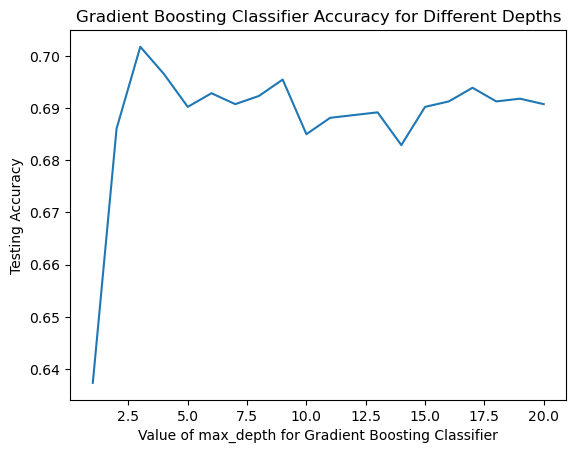

In [12]:
# Gradient Boosting
scores = []
depths = range(1, 21)
for depth in depths:
    gbr = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=depth, random_state=2024)
    gbr.fit(x_train, y_train)
    y_pred = gbr.predict(x_test)
    scores.append(accuracy_score(y_test, y_pred))

plt.plot(depths, scores)
plt.xlabel('Value of max_depth for Gradient Boosting Classifier')
plt.ylabel('Testing Accuracy')
plt.title('Gradient Boosting Classifier Accuracy for Different Depths')
plt.show()



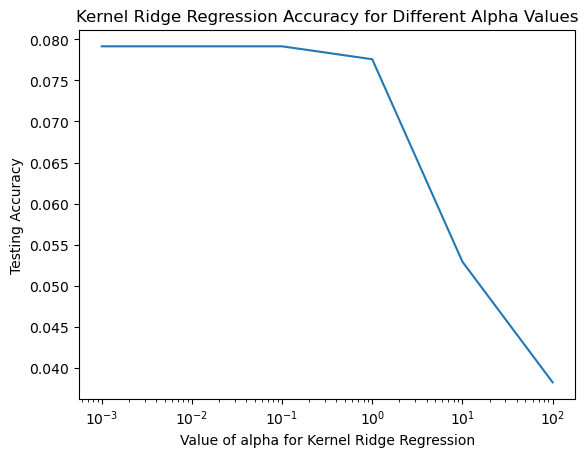

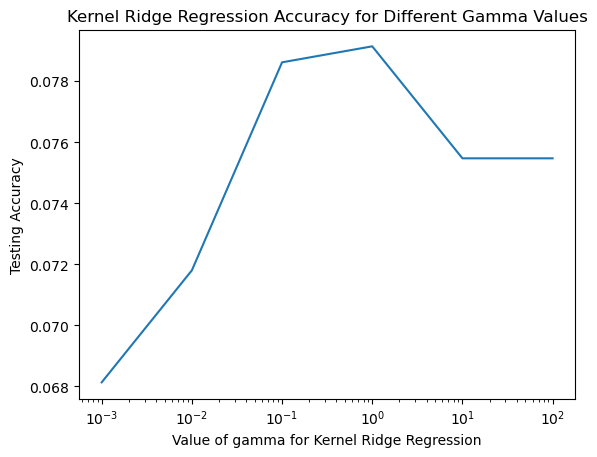

In [13]:
# Kernel Ridge Regression with different alpha values
scores = []
alphas = [0.001, 0.01, 0.1, 1, 10, 100]  
for alpha in alphas:
    model = KernelRidge(alpha=alpha, kernel='rbf', gamma=1.0)
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    y_pred = [1 if p > 0.5 else 0 for p in predictions]  
    scores.append(accuracy_score(y_test, y_pred))

plt.plot(alphas, scores)
plt.xscale('log')
plt.xlabel('Value of alpha for Kernel Ridge Regression')
plt.ylabel('Testing Accuracy')
plt.title('Kernel Ridge Regression Accuracy for Different Alpha Values')
plt.show()

# Kernel Ridge Regression for different gamma values

scores = []
gammas = [0.001, 0.01, 0.1, 1, 10, 100]  
for gamma in gammas:
    model = KernelRidge(alpha=0.1, kernel='rbf', gamma=gamma)
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    y_pred = [1 if p > 0.5 else 0 for p in predictions]
    scores.append(accuracy_score(y_test, y_pred))

plt.plot(gammas, scores)
plt.xscale('log')
plt.xlabel('Value of gamma for Kernel Ridge Regression')
plt.ylabel('Testing Accuracy')
plt.title('Kernel Ridge Regression Accuracy for Different Gamma Values')
plt.show()

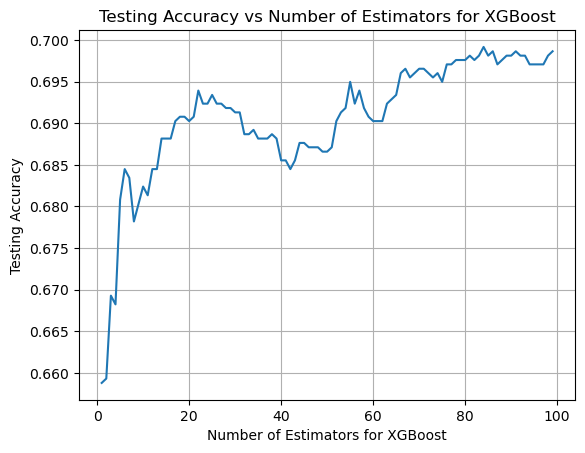

In [14]:
# List to store accuracy scores
xgboost_scores = []

# Loop over a range of n_estimators values
for n in range(1, 100):
    xgboost_model = xgb.XGBClassifier(n_estimators=n, learning_rate=0.1, random_state=2024, verbosity=0)
    xgboost_model.fit(x_train, y_train)
    y_pred = xgboost_model.predict(x_test)
    score = accuracy_score(y_test, y_pred)
    xgboost_scores.append(score)

# Plotting the results
plt.plot(range(1, 100), xgboost_scores)
plt.xlabel('Number of Estimators for XGBoost')
plt.ylabel('Testing Accuracy')
plt.title('Testing Accuracy vs Number of Estimators for XGBoost')
plt.grid(True)
plt.show()

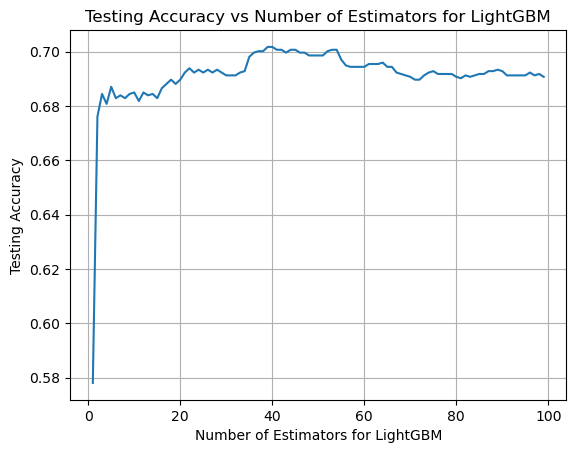

In [15]:
# List to store accuracy scores
lightgbm_scores = []

# Loop over a range of n_estimators values
for n in range(1, 100):
    lgbm_model = lgb.LGBMClassifier(n_estimators=n, learning_rate=0.1, random_state=2024, verbose=-1)
    lgbm_model.fit(x_train, y_train)
    y_pred = lgbm_model.predict(x_test)
    score = accuracy_score(y_test, y_pred)
    lightgbm_scores.append(score)

# Plotting the results
plt.plot(range(1, 100), lightgbm_scores)
plt.xlabel('Number of Estimators for LightGBM')
plt.ylabel('Testing Accuracy')
plt.title('Testing Accuracy vs Number of Estimators for LightGBM')
plt.grid(True)
plt.show()

In [16]:
## Neural network for classification
from keras.models import Sequential
from keras.layers import Dense
from keras import backend

dummy_y = to_categorical(y, num_classes=None)
scaler = StandardScaler()
data = scaler.fit_transform(data)

X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(data, dummy_y, test_size=0.3)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)

In [17]:
print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)

(6675, 4) (1431, 4) (1431, 4) (6675, 12) (1431, 12) (1431, 12)


In [21]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(4,), kernel_initializer="normal"),
    Dense(64, activation='relu', kernel_initializer="normal"),
    Dense(12, activation='softmax', kernel_initializer="normal"),
])

In [22]:
# Create the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
hist = model.fit(X_train, Y_train,
          batch_size=30, epochs=65,
          validation_data=(X_val, Y_val))

Epoch 1/65
223/223 [==============================] - 1s 3ms/step - loss: 2.1604 - accuracy: 0.2542 - val_loss: 1.9602 - val_accuracy: 0.3103
Epoch 2/65
223/223 [==============================] - 0s 2ms/step - loss: 1.8684 - accuracy: 0.3456 - val_loss: 1.8741 - val_accuracy: 0.3641
Epoch 3/65
223/223 [==============================] - 0s 2ms/step - loss: 1.7874 - accuracy: 0.3633 - val_loss: 1.8150 - val_accuracy: 0.3704
Epoch 4/65
223/223 [==============================] - 0s 2ms/step - loss: 1.7281 - accuracy: 0.3769 - val_loss: 1.7738 - val_accuracy: 0.3836
Epoch 5/65
223/223 [==============================] - 0s 1ms/step - loss: 1.6848 - accuracy: 0.3801 - val_loss: 1.7372 - val_accuracy: 0.3795
Epoch 6/65
223/223 [==============================] - 0s 2ms/step - loss: 1.6539 - accuracy: 0.3823 - val_loss: 1.7245 - val_accuracy: 0.3892
Epoch 7/65
223/223 [==============================] - 0s 2ms/step - loss: 1.6321 - accuracy: 0.3853 - val_loss: 1.6929 - val_accuracy: 0.3927
Epoch 

In [24]:
model.evaluate(X_test, Y_test)[1]

45/45 [==============================] - 0s 1ms/step - loss: 1.0782 - accuracy: 0.5940


0.5939902067184448

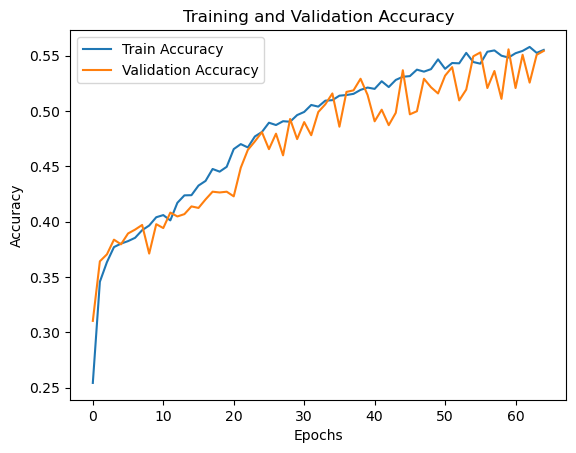

In [33]:
import numpy as np
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.show()

# Plot the accuracy
plot_accuracy(hist)